# DATA

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# # 2. Path to your zip file on Drive
# zip_path = "/content/drive/MyDrive/NU - 1st Submission/Data/AIDER.zip"

# # 3. Unzip the file
# import zipfile
# import os

# extract_path = "/content/dataset"
# os.makedirs(extract_path, exist_ok=True)

In [ ]:
import os, glob, random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import os, glob, random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
class EfficientNetV2Dataset(Dataset):
    def __init__(self, dataset_root, split="train", train_ratio=0.5, val_ratio=0.2, 
                 use_table2=False, seed=42, input_size=384):  # ✅ Fixed __init__
        self.split = split
        self.use_table2 = use_table2
        self.seed = seed
        self.input_size = input_size
        self.class_names = ["collapsed_building", "fire", "flooded_areas", "normal", "traffic_incident"]
        self.class_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        
        # EfficientNetV2-S specific preprocessing for validation/test
        self.base_transforms = transforms.Compose([
            transforms.Resize((self.input_size, self.input_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
        
        # Enhanced augmentation for training (non-normal classes only)
        self.augment_transforms = A.Compose([
            A.Resize(int(self.input_size*1.08), int(self.input_size*1.08)),
            A.RandomCrop(self.input_size, self.input_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Rotate(limit=30, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.CLAHE(p=0.2),
            A.RandomShadow(p=0.2),
           
            A.GaussianBlur(blur_limit=(3, 7), p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ]) if split == "train" else None
        
        # Load images with the chosen strategy
        self.images = self._load_images_with_splits(dataset_root, split, train_ratio, val_ratio)
        
        # Print distribution
        class_counts = {}
        for _, class_name in self.images:
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        print(f"📊 {split.upper()} Base Class Distribution:")
        for class_name, count in class_counts.items():
            aug_status = "❌ (No Aug)" if class_name == "normal" else "✅ (Augmented)"
            print(f"   {class_name}: {count} images {aug_status}")
        
        print(f"📊 {split.upper()} Dataset: {len(self.images)} base images")
        
        if split == "train":
            augmented_classes = [name for name in self.class_names if name != "normal"]
            print(f"🔄 Augmentation applied to: {', '.join(augmented_classes)}")
            print(f"🚫 No augmentation for: normal")
            
        # Initialize augmentation counter
        self.aug_counts = {}
    
    def _load_images_with_splits(self, dataset_root, split, train_ratio=0.5, val_ratio=0.2):  # ✅ Fixed indentation
        rng = random.Random(self.seed)
        
        TARGET = {
            "collapsed_building": {"train": 367, "val": 41,  "test": 103},
            "fire":               {"train": 249, "val": 63,  "test": 209},
            "flooded_areas":      {"train": 252, "val": 63,  "test": 211},
            "traffic_incident":   {"train": 232, "val": 59,  "test": 194},
            "normal":             {"train": 2107,"val": 527, "test": 1756},
        }
        
        split_data = []
        for class_name in self.class_names:
            class_path = os.path.join(dataset_root, class_name)
            if not os.path.exists(class_path):
                print(f"⚠️ Warning: {class_path} not found")
                continue
                
            # Fix glob patterns
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']  # ✅ Fixed typo
            image_paths = []
            for ext in image_extensions:
                image_paths.extend(glob.glob(os.path.join(class_path, ext)))
                image_paths.extend(glob.glob(os.path.join(class_path, ext.upper())))
            
            rng.shuffle(image_paths)
            print(f"📁 Found {len(image_paths)} images in {class_name}")
            
            if self.use_table2:
                # ✅ CORRECT: Calculate cumulative splits to avoid overlap
                train_count = TARGET[class_name]["train"]
                val_count = TARGET[class_name]["val"] 
                test_count = TARGET[class_name]["test"]
                
                # Verify we have enough images
                total_needed = train_count + val_count + test_count
                if len(image_paths) < total_needed:
                    print(f"⚠️ Warning: {class_name} has {len(image_paths)} images, but needs {total_needed}")
                
                if split == "train":
                    class_images = image_paths[:train_count]
                elif split == "val":
                    class_images = image_paths[train_count:train_count + val_count]
                else:  # test
                    class_images = image_paths[train_count + val_count:train_count + val_count + test_count]
            else:
                # Ratio-based splitting
                total_images = len(image_paths)
                train_end = int(total_images * train_ratio)
                val_end = int(total_images * (train_ratio + val_ratio))
                
                if split == "train":
                    class_images = image_paths[:train_end]
                elif split == "val":
                    class_images = image_paths[train_end:val_end]
                else:  # test
                    class_images = image_paths[val_end:]
            
            for img_path in class_images:
                split_data.append((img_path, class_name))
                
            print(f"📊 {class_name} - {split}: {len(class_images)} images")
        
        rng.shuffle(split_data)
        return split_data
    
    def __len__(self):  # ✅ Fixed __len__
        return len(self.images)
    
    def __getitem__(self, idx):  # ✅ Fixed __getitem__
        image_path, class_name = self.images[idx]
        
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"⚠️ Error loading image {image_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (self.input_size, self.input_size), (0, 0, 0))
        
        # Determine if we should augment
        should_augment = (
            self.split == "train" and 
            class_name != "normal" and 
            self.augment_transforms is not None
        )
        
        # Apply appropriate transforms
        if should_augment:
            # Convert PIL image to numpy array before Albumentations!
            image = np.array(image)
            image = self.augment_transforms(image=image)["image"]
            # Track augmentation counts
            self.aug_counts[class_name] = self.aug_counts.get(class_name, 0) + 1
        else:
            image = self.base_transforms(image)

        return {
            'image': image,
            'labels': self.class_to_idx[class_name],
            'class_name': class_name,
            'was_augmented': should_augment,
            'image_path': image_path  # For debugging
        }
    
    def get_class_distribution(self):
        """Get the distribution of classes in the dataset"""
        class_counts = {}
        for _, class_name in self.images:
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        return class_counts
    
    def get_augmentation_stats(self):
        """Get augmentation statistics (only meaningful after some training)"""
        if not hasattr(self, 'aug_counts') or not self.aug_counts:
            return "No augmentation data available"
        
        total_aug = sum(self.aug_counts.values())
        stats = f"Total augmentations applied: {total_aug}\n"
        for class_name, count in self.aug_counts.items():
            percentage = (count / total_aug) * 100 if total_aug > 0 else 0
            stats += f"  {class_name}: {count} ({percentage:.1f}%)\n"
        return stats
    
    def reset_augmentation_stats(self):
        """Reset augmentation counters"""
        self.aug_counts = {}


# Usage example
if __name__ == "__main__":
    # Test the dataset
    dataset_root = "/kaggle/input/aider2/AIDER"
    
    # Create datasets
    train_dataset = EfficientNetV2Dataset(
        dataset_root=dataset_root,
        split="train",
        use_table2=True,
        input_size=384  # EfficientNetV2-S input size
    )
    
    val_dataset = EfficientNetV2Dataset(
        dataset_root=dataset_root,
        split="val",
        use_table2=True,
        input_size=384
    )
    test_dataset = EfficientNetV2Dataset(
        dataset_root=dataset_root,
        split="test",
        use_table2=True,
        input_size=384
    )
    # Test loading a sample
    sample = train_dataset[0]
    print(f"Sample shape: {sample['image'].shape}")
    print(f"Sample label: {sample['labels']} ({sample['class_name']})")
    print(f"Was augmented: {sample['was_augmented']}")
    
    # Print class distribution
    print("\nClass distribution:")
    distribution = train_dataset.get_class_distribution()
    for class_name, count in distribution.items():
        print(f"  {class_name}: {count}")


📁 Found 511 images in collapsed_building
📊 collapsed_building - train: 367 images
📁 Found 521 images in fire
📊 fire - train: 249 images
📁 Found 526 images in flooded_areas
📊 flooded_areas - train: 252 images
📁 Found 4390 images in normal
📊 normal - train: 2107 images
📁 Found 485 images in traffic_incident
📊 traffic_incident - train: 232 images
📊 TRAIN Base Class Distribution:
   traffic_incident: 232 images ✅ (Augmented)
   collapsed_building: 367 images ✅ (Augmented)
   fire: 249 images ✅ (Augmented)
   normal: 2107 images ❌ (No Aug)
   flooded_areas: 252 images ✅ (Augmented)
📊 TRAIN Dataset: 3207 base images
🔄 Augmentation applied to: collapsed_building, fire, flooded_areas, traffic_incident
🚫 No augmentation for: normal
📁 Found 511 images in collapsed_building
📊 collapsed_building - val: 41 images
📁 Found 521 images in fire
📊 fire - val: 63 images
📁 Found 526 images in flooded_areas
📊 flooded_areas - val: 63 images
📁 Found 4390 images in normal
📊 normal - val: 527 images
📁 Found 485

# Efficiency Net V2

3.2.2. Detection Model Implementation Details

4.1.3 Experiment A — EfficientNetV2-S: Detection Module Architecture and Fine-Tuning

In [4]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s

class DisasterClassifier(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super(DisasterClassifier, self).__init__()
        
        # Load pre-trained EfficientNetV2-S
        self.backbone = efficientnet_v2_s(weights='IMAGENET1K_V1')
        
        # Replace classifier
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Initialize model
model = DisasterClassifier(num_classes=5)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 178MB/s] 


In [ ]:
# ⚠️ UPDATE THIS PATH TO YOUR DATASET
DATASET_ROOT = "/kaggle/input/aider2/AIDER"  # CHANGE THIS!

CONFIG = {
    'dataset_root': DATASET_ROOT,
    'batch_size': 32,
    'learning_rate': 2e-4,
    'num_epochs': 50,
    'patience': 10,
    'save_dir': './models',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'use_table2': True
}

# Create save directory
os.makedirs(CONFIG['save_dir'], exist_ok=True)

print(f"💻 Device: {CONFIG['device']}")
print(f"📁 Dataset path: {CONFIG['dataset_root']}")
print(f"🏗️ Save directory: {CONFIG['save_dir']}")
print(f"📦 Batch size: {CONFIG['batch_size']}")


💻 Device: cuda
📁 Dataset path: /kaggle/input/aider2/AIDER
🏗️ Save directory: ./models
📦 Batch size: 64


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Create datasets
train_dataset = EfficientNetV2Dataset(dataset_root, split="train", use_table2=True)
val_dataset = EfficientNetV2Dataset(dataset_root, split="val", use_table2=True)
test_dataset = EfficientNetV2Dataset(dataset_root, split="test", use_table2=True)

# Your existing class weighting code
labels = [int(sample["labels"]) for sample in train_dataset]
classes = np.unique(labels)
class_counts = np.array([(labels == c).sum() for c in classes], dtype=np.int64)
class_weight = {c: 1.0 / cnt for c, cnt in zip(classes, class_counts)}
sample_weights = np.array([class_weight[int(l)] for l in labels], dtype=np.float64)

# Create sampler
sampler = WeightedRandomSampler(
    weights=torch.from_numpy(sample_weights).double(),
    num_samples=len(sample_weights),
    replacement=True
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)


📁 Found 511 images in collapsed_building
📊 collapsed_building - train: 367 images
📁 Found 521 images in fire
📊 fire - train: 249 images
📁 Found 526 images in flooded_areas
📊 flooded_areas - train: 252 images
📁 Found 4390 images in normal
📊 normal - train: 2107 images
📁 Found 485 images in traffic_incident
📊 traffic_incident - train: 232 images
📊 TRAIN Base Class Distribution:
   traffic_incident: 232 images ✅ (Augmented)
   collapsed_building: 367 images ✅ (Augmented)
   fire: 249 images ✅ (Augmented)
   normal: 2107 images ❌ (No Aug)
   flooded_areas: 252 images ✅ (Augmented)
📊 TRAIN Dataset: 3207 base images
🔄 Augmentation applied to: collapsed_building, fire, flooded_areas, traffic_incident
🚫 No augmentation for: normal
📁 Found 511 images in collapsed_building
📊 collapsed_building - val: 41 images
📁 Found 521 images in fire
📊 fire - val: 63 images
📁 Found 526 images in flooded_areas
📊 flooded_areas - val: 63 images
📁 Found 4390 images in normal
📊 normal - val: 527 images
📁 Found 485

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
class_names = train_dataset.class_names
model = DisasterClassifier(num_classes=len(class_names))
device = torch.device(CONFIG['device'])
model = model.to(device)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

# Loss function with class weights
class_weights_tensor = torch.FloatTensor([class_weight[i] for i in range(len(class_names))]).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Optimizer with different learning rates
optimizer = optim.AdamW([
    {'params': model.backbone.features.parameters(), 'lr': CONFIG['learning_rate'] * 0.1},
    {'params': model.backbone.classifier.parameters(), 'lr': CONFIG['learning_rate']}
], weight_decay=0.01)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

print("✅ Model and training components initialized!")


📊 Model Statistics:
   Total parameters: 20,835,925
   Trainable parameters: 20,835,925
✅ Model and training components initialized!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def train_epoch(model, loader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch} - Training')
    for batch in pbar:
        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device, class_names):
    """Validate the model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validating')
        for batch in pbar:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    report = classification_report(
        all_labels, all_preds, 
        target_names=class_names, 
        output_dict=True
    )
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    return total_loss / len(loader), 100. * correct / total, report

print("✅ Training functions defined!")


✅ Training functions defined!


PyTorch version: 2.6.0+cu124
CUDA available: True
🚀 Starting training...

📊 Epoch 1/50


Validating: 100%|██████████| 24/24 [00:16<00:00,  1.46it/s, Loss=0.5769, Acc=91.37%]


[[ 36   0   0   3   2]
 [  0  60   0   3   0]
 [  0   0  60   3   0]
 [  3   9  23 482  10]
 [  3   1   1   4  50]]


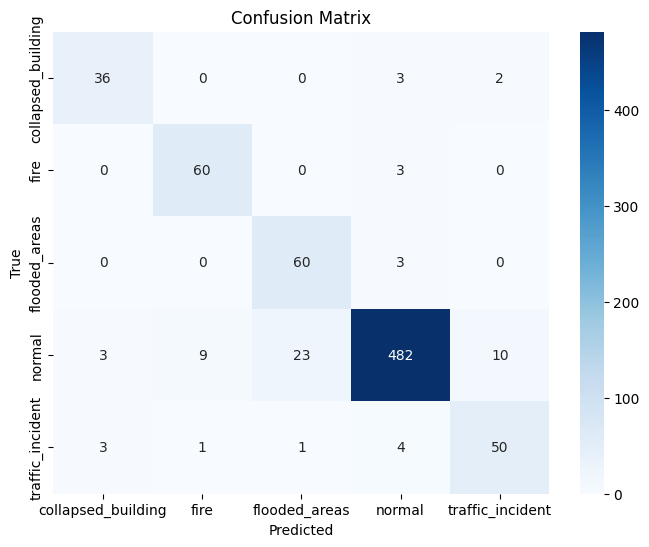

📈 Train - Loss: 0.9192, Acc: 80.26%
📊 Val - Loss: 0.5851, Acc: 91.37%
🎯 F1-Score: 0.8711
💾 New best model saved! Val Acc: 91.37%

📊 Epoch 2/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s, Loss=0.5403, Acc=94.42%]


[[ 35   1   0   2   3]
 [  0  61   0   2   0]
 [  0   0  60   3   0]
 [  5   5   8 504   5]
 [  3   1   0   4  51]]


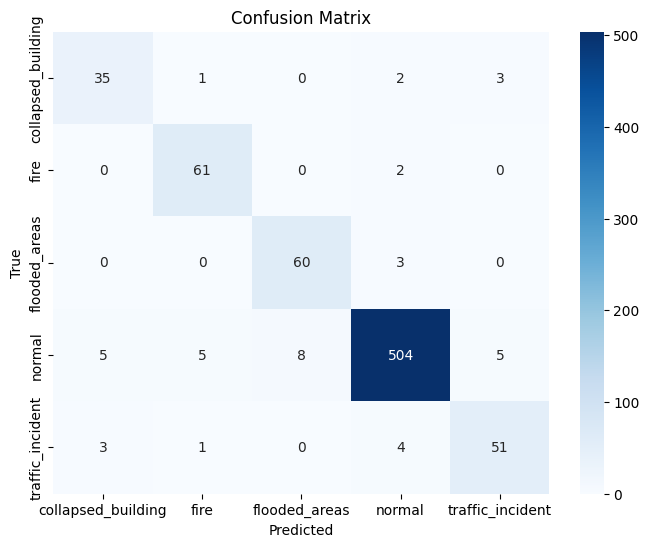

📈 Train - Loss: 0.5408, Acc: 94.17%
📊 Val - Loss: 0.5193, Acc: 94.42%
🎯 F1-Score: 0.9025
💾 New best model saved! Val Acc: 94.42%

📊 Epoch 3/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s, Loss=0.4638, Acc=96.15%]


[[ 37   0   0   3   1]
 [  0  62   0   1   0]
 [  0   0  60   3   0]
 [  3   4   2 515   3]
 [  3   1   0   5  50]]


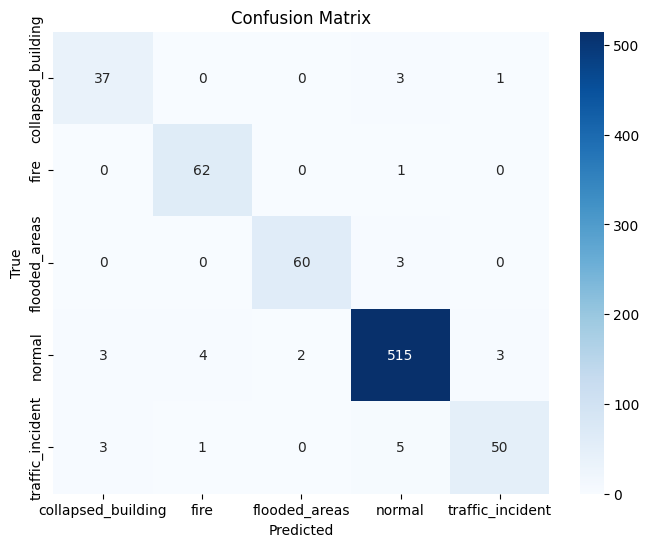

📈 Train - Loss: 0.5035, Acc: 95.95%
📊 Val - Loss: 0.4861, Acc: 96.15%
🎯 F1-Score: 0.9314
💾 New best model saved! Val Acc: 96.15%

📊 Epoch 4/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s, Loss=0.4426, Acc=96.28%]


[[ 35   1   0   4   1]
 [  0  62   0   1   0]
 [  0   0  60   3   0]
 [  2   2   1 520   2]
 [  3   1   0   7  48]]


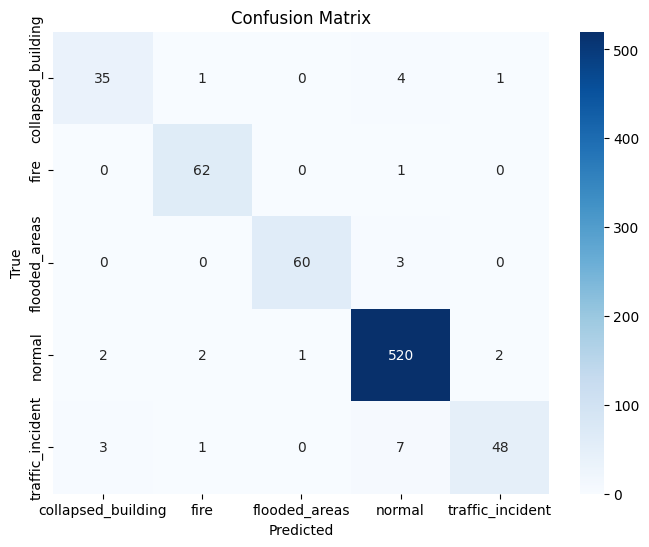

📈 Train - Loss: 0.4769, Acc: 97.07%
📊 Val - Loss: 0.4707, Acc: 96.28%
🎯 F1-Score: 0.9290
💾 New best model saved! Val Acc: 96.28%

📊 Epoch 5/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s, Loss=0.4659, Acc=97.08%]


[[ 37   0   0   3   1]
 [  0  62   0   1   0]
 [  0   0  61   2   0]
 [  1   3   1 519   3]
 [  2   1   0   4  52]]


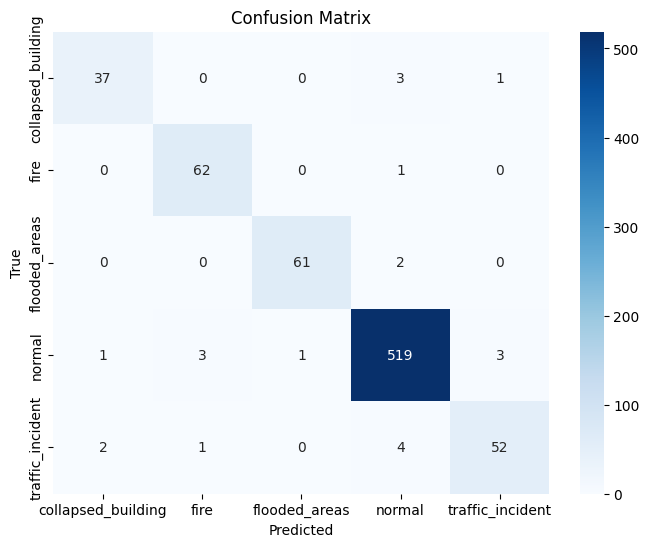

📈 Train - Loss: 0.4652, Acc: 98.07%
📊 Val - Loss: 0.4605, Acc: 97.08%
🎯 F1-Score: 0.9476
💾 New best model saved! Val Acc: 97.08%

📊 Epoch 6/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s, Loss=0.4924, Acc=98.01%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   1 521   3]
 [  1   0   0   3  55]]


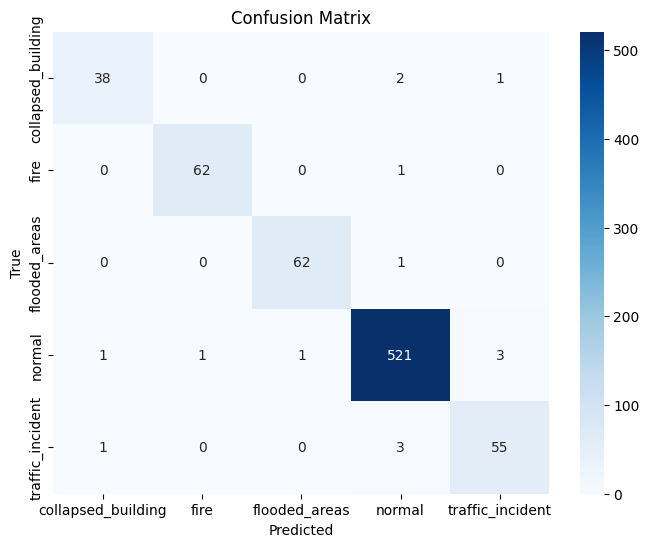

📈 Train - Loss: 0.4465, Acc: 98.47%
📊 Val - Loss: 0.4518, Acc: 98.01%
🎯 F1-Score: 0.9653
💾 New best model saved! Val Acc: 98.01%

📊 Epoch 7/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s, Loss=0.4486, Acc=97.61%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  61   2   0]
 [  1   1   1 521   3]
 [  1   0   0   5  53]]


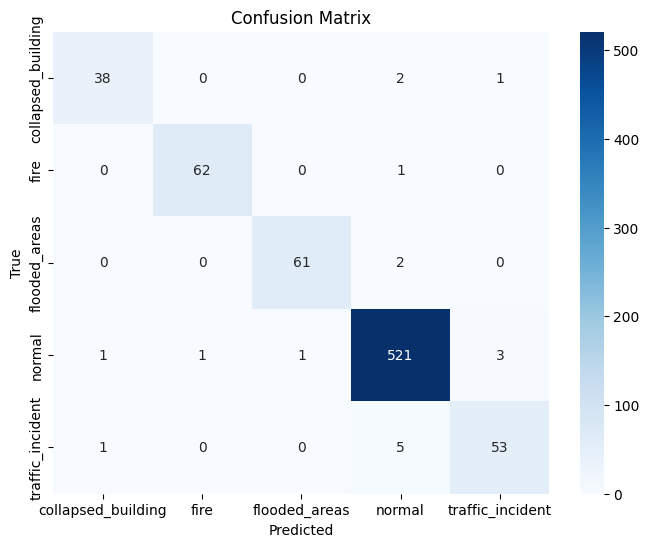

📈 Train - Loss: 0.4423, Acc: 98.63%
📊 Val - Loss: 0.4492, Acc: 97.61%
🎯 F1-Score: 0.9594

📊 Epoch 8/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s, Loss=0.4467, Acc=97.88%]


[[ 38   0   0   2   1]
 [  0  63   0   0   0]
 [  0   0  61   2   0]
 [  1   1   1 521   3]
 [  1   0   0   4  54]]


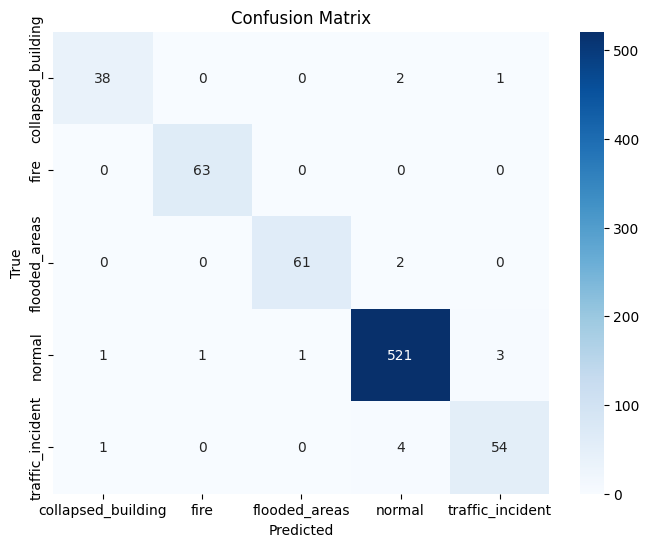

📈 Train - Loss: 0.4368, Acc: 98.97%
📊 Val - Loss: 0.4503, Acc: 97.88%
🎯 F1-Score: 0.9632

📊 Epoch 9/50


Validating: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s, Loss=0.4497, Acc=97.88%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   1 521   3]
 [  1   0   0   4  54]]


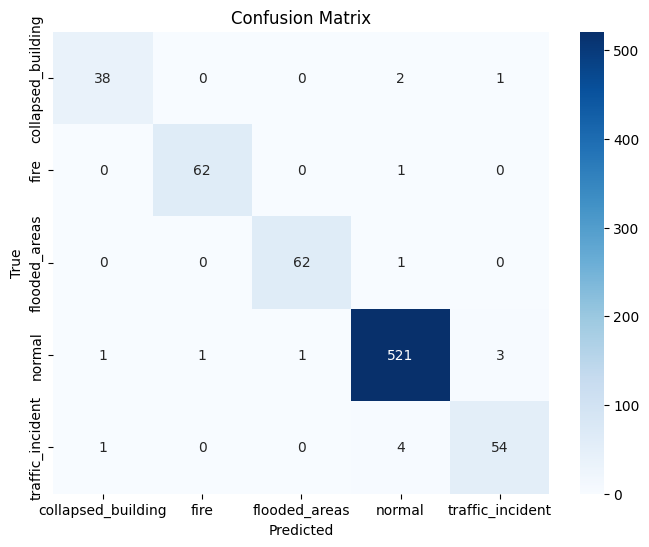

📈 Train - Loss: 0.4246, Acc: 99.31%
📊 Val - Loss: 0.4426, Acc: 97.88%
🎯 F1-Score: 0.9633

📊 Epoch 10/50


Validating: 100%|██████████| 24/24 [00:12<00:00,  1.93it/s, Loss=0.4532, Acc=97.88%]


[[ 37   0   0   1   3]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   1 521   3]
 [  1   0   0   3  55]]


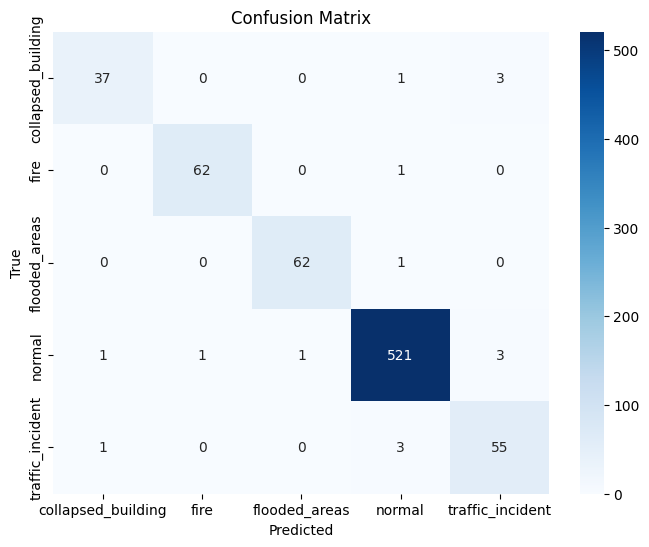

📈 Train - Loss: 0.4230, Acc: 99.16%
📊 Val - Loss: 0.4413, Acc: 97.88%
🎯 F1-Score: 0.9597

📊 Epoch 11/50


Validating: 100%|██████████| 24/24 [00:12<00:00,  1.95it/s, Loss=0.4089, Acc=97.74%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  61   2   0]
 [  1   2   0 521   3]
 [  1   0   0   4  54]]


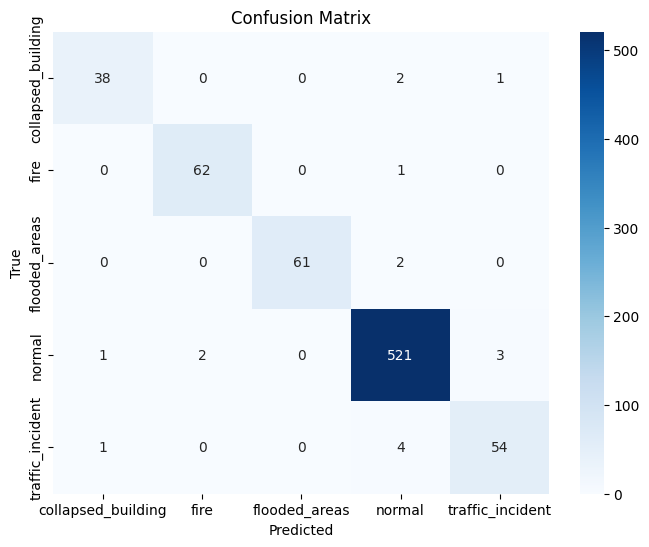

📈 Train - Loss: 0.4187, Acc: 99.66%
📊 Val - Loss: 0.4431, Acc: 97.74%
🎯 F1-Score: 0.9615

📊 Epoch 12/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.00it/s, Loss=0.4284, Acc=97.61%]


[[ 38   0   0   2   1]
 [  0  63   0   0   0]
 [  0   0  62   1   0]
 [  1   6   0 518   2]
 [  1   0   0   4  54]]


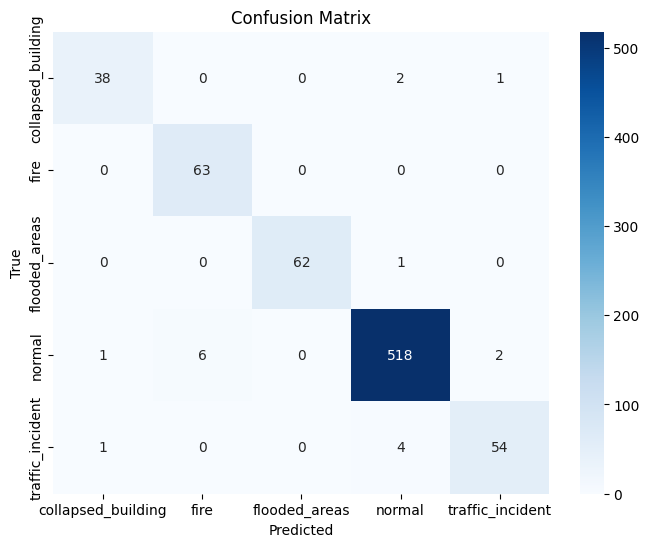

📈 Train - Loss: 0.4185, Acc: 99.38%
📊 Val - Loss: 0.4488, Acc: 97.61%
🎯 F1-Score: 0.9601

📊 Epoch 13/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s, Loss=0.4242, Acc=98.27%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   0 523   2]
 [  1   0   0   3  55]]


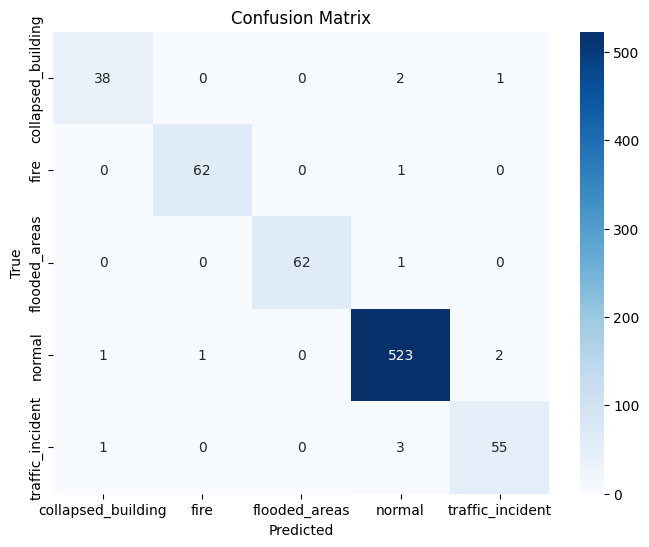

📈 Train - Loss: 0.4149, Acc: 99.47%
📊 Val - Loss: 0.4383, Acc: 98.27%
🎯 F1-Score: 0.9688
💾 New best model saved! Val Acc: 98.27%

📊 Epoch 14/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s, Loss=0.4598, Acc=98.14%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   1 522   2]
 [  1   0   0   3  55]]


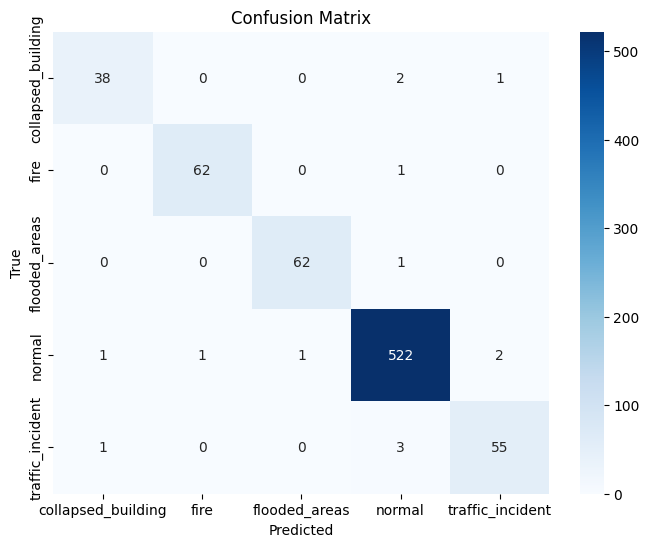

📈 Train - Loss: 0.4114, Acc: 99.66%
📊 Val - Loss: 0.4404, Acc: 98.14%
🎯 F1-Score: 0.9671

📊 Epoch 15/50


Validating: 100%|██████████| 24/24 [00:12<00:00,  1.97it/s, Loss=0.4220, Acc=98.01%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   0 523   2]
 [  1   1   0   4  53]]


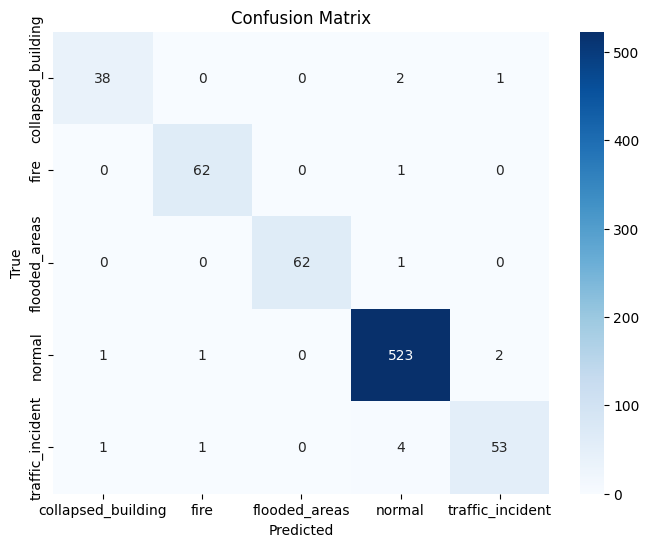

📈 Train - Loss: 0.4122, Acc: 99.66%
📊 Val - Loss: 0.4377, Acc: 98.01%
🎯 F1-Score: 0.9634

📊 Epoch 16/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s, Loss=0.4534, Acc=97.74%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   2   1 521   2]
 [  1   0   0   5  53]]


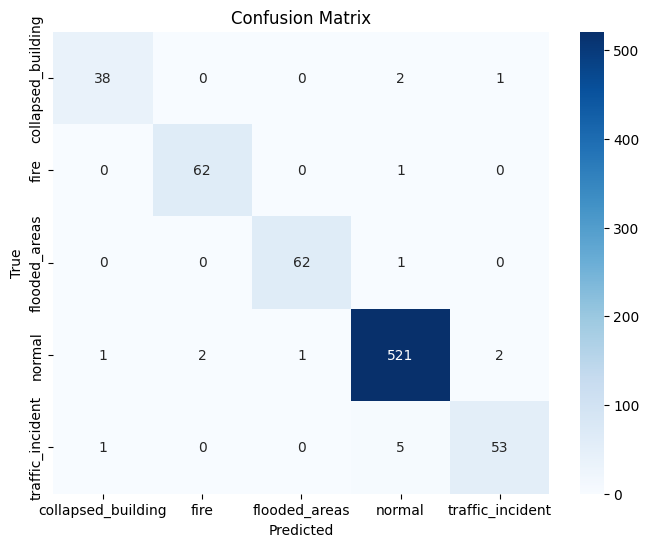

📈 Train - Loss: 0.4125, Acc: 99.50%
📊 Val - Loss: 0.4400, Acc: 97.74%
🎯 F1-Score: 0.9613

📊 Epoch 17/50


Validating: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s, Loss=0.4437, Acc=97.88%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   1 522   2]
 [  1   0   0   5  53]]


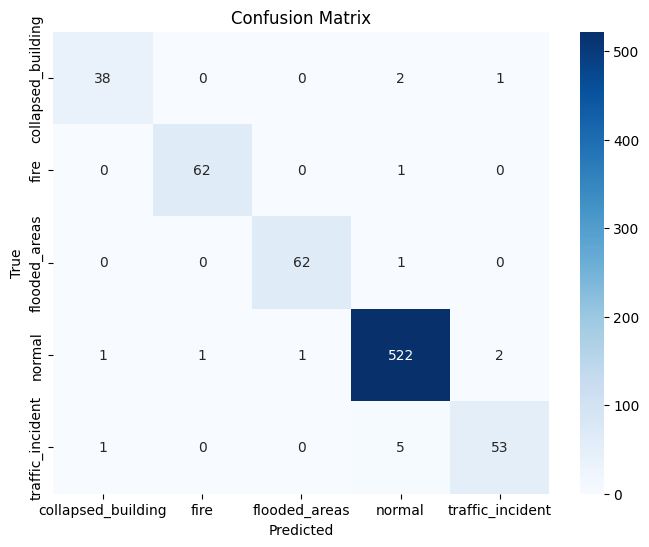

📈 Train - Loss: 0.4147, Acc: 99.56%
📊 Val - Loss: 0.4411, Acc: 97.88%
🎯 F1-Score: 0.9630

📊 Epoch 18/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s, Loss=0.4519, Acc=97.74%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  2   2   1 520   2]
 [  1   0   0   4  54]]


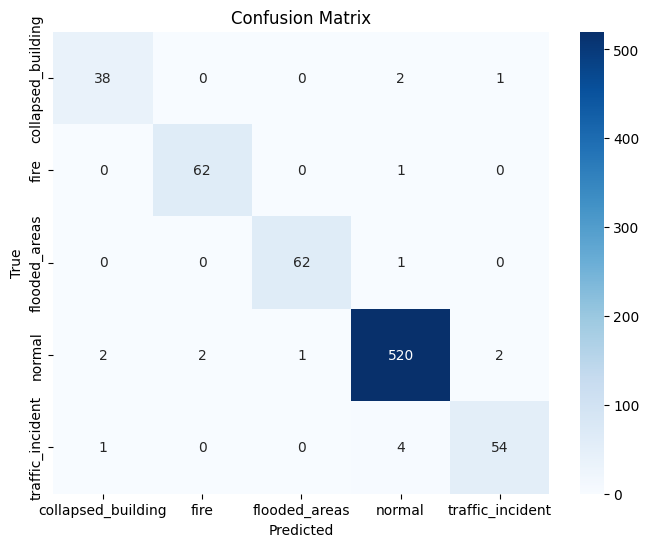

📈 Train - Loss: 0.4082, Acc: 99.69%
📊 Val - Loss: 0.4411, Acc: 97.74%
🎯 F1-Score: 0.9608

📊 Epoch 19/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.03it/s, Loss=0.4292, Acc=98.01%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   1 522   2]
 [  1   1   0   3  54]]


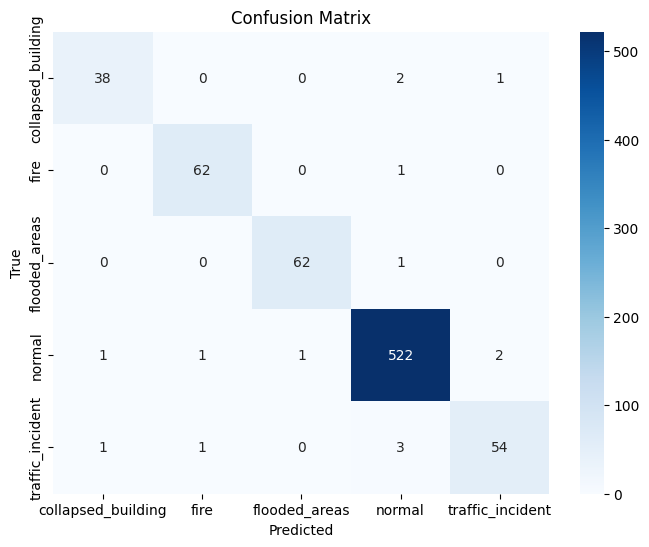

📈 Train - Loss: 0.4158, Acc: 99.44%
📊 Val - Loss: 0.4381, Acc: 98.01%
🎯 F1-Score: 0.9637

📊 Epoch 20/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.04it/s, Loss=0.4150, Acc=98.01%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   0 523   2]
 [  1   1   0   4  53]]


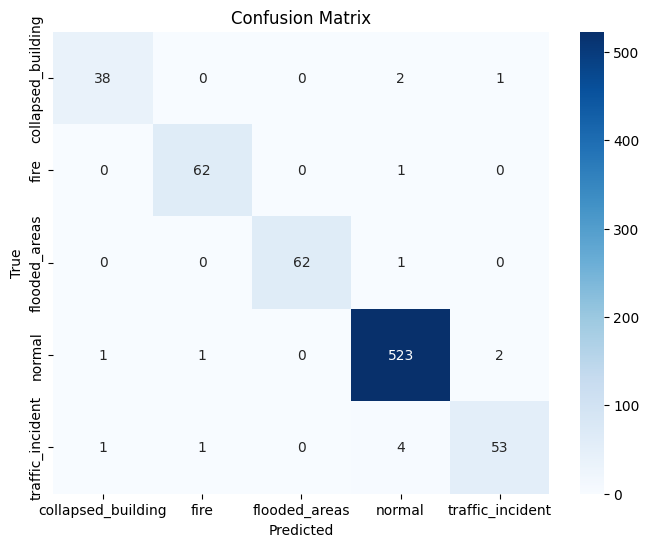

📈 Train - Loss: 0.4087, Acc: 99.63%
📊 Val - Loss: 0.4395, Acc: 98.01%
🎯 F1-Score: 0.9634

📊 Epoch 21/50


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.02it/s, Loss=0.4123, Acc=98.14%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   0 523   2]
 [  1   0   0   4  54]]


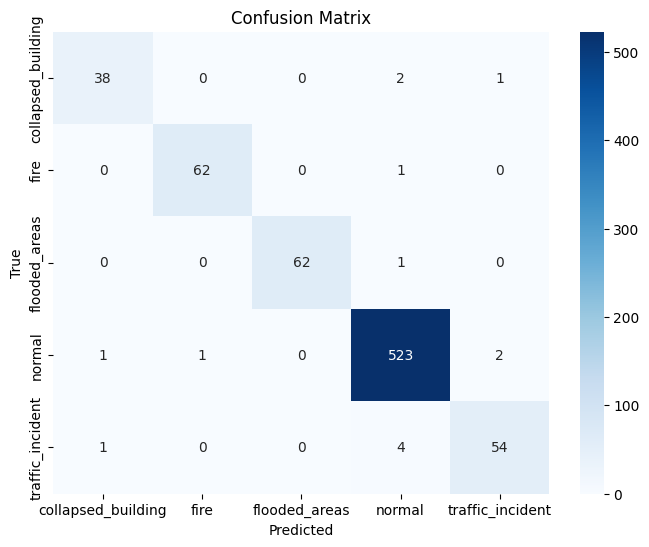

📈 Train - Loss: 0.4091, Acc: 99.81%
📊 Val - Loss: 0.4396, Acc: 98.14%
🎯 F1-Score: 0.9668

📊 Epoch 22/50


Validating: 100%|██████████| 24/24 [00:12<00:00,  1.98it/s, Loss=0.4191, Acc=98.14%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  0   1   0 524   2]
 [  1   1   0   4  53]]


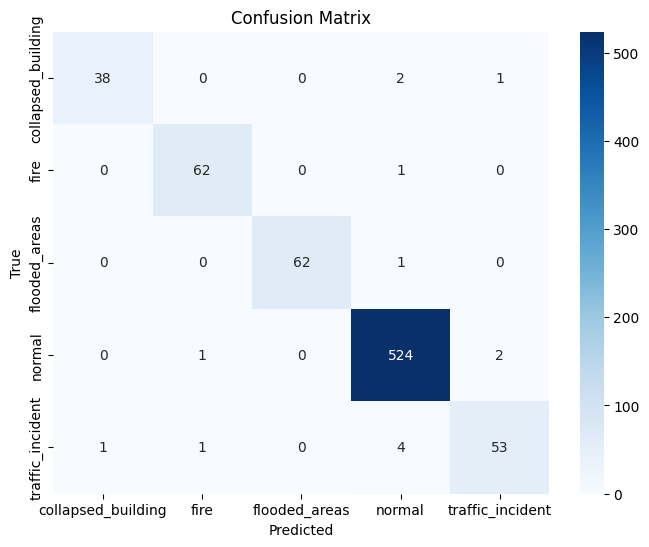

📈 Train - Loss: 0.4105, Acc: 99.50%
📊 Val - Loss: 0.4373, Acc: 98.14%
🎯 F1-Score: 0.9659

📊 Epoch 23/50


Validating: 100%|██████████| 24/24 [00:12<00:00,  1.99it/s, Loss=0.4211, Acc=98.14%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  0   1   0 524   2]
 [  1   0   0   5  53]]


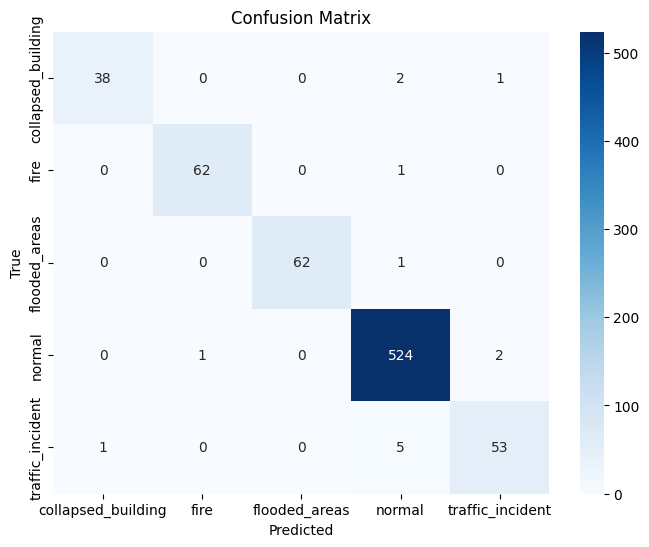

📈 Train - Loss: 0.4039, Acc: 99.91%
📊 Val - Loss: 0.4375, Acc: 98.14%
🎯 F1-Score: 0.9673
🛑 Early stopping triggered after 23 epochs

⏱️ Training completed in 54.5 minutes
🏆 Best validation accuracy: 98.27%


In [9]:
# Install required packages (run only once)

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
from torchvision.models import efficientnet_v2_s

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

best_val_acc = 0
train_losses = []
train_accs = []
val_losses = []
val_accs = []
patience_counter = 0

print("🚀 Starting training...")
start_time = time.time()

for epoch in range(1, CONFIG['num_epochs'] + 1):
    print(f"\n📊 Epoch {epoch}/{CONFIG['num_epochs']}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    
    # Validate
    val_loss, val_acc, val_report = validate(model, val_loader, criterion, device, class_names)
    
    # Update scheduler
    scheduler.step(val_acc)
    
    # Track metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print results
    print(f"📈 Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"📊 Val - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    print(f"🎯 F1-Score: {val_report['macro avg']['f1-score']:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_report': val_report,
            'class_names': class_names
        }, os.path.join(CONFIG['save_dir'], 'best_model.pth'))
        print(f"💾 New best model saved! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"🛑 Early stopping triggered after {epoch} epochs")
        break

training_time = time.time() - start_time
print(f"\n⏱️ Training completed in {training_time/60:.1f} minutes")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")


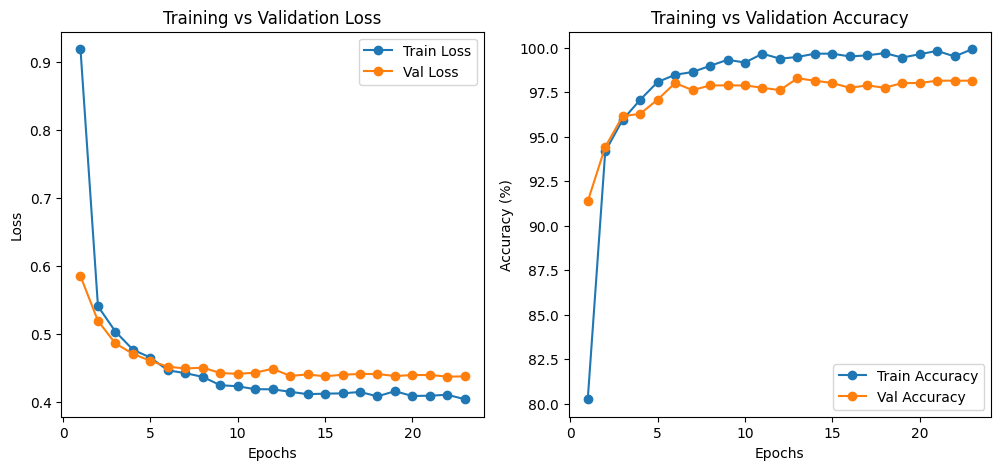

In [10]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12,5))

    # 🔹 Plot Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o")
    plt.plot(epochs, val_losses, label="Val Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # 🔹 Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label="Train Accuracy", marker="o")
    plt.plot(epochs, val_accs, label="Val Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.show()

# 👉 Call this after training is done
plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs)


In [11]:
from sklearn.metrics import confusion_matrix

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Load best model

In [12]:
# Specify paths
MODEL_PATH = "/kaggle/working/models/best_model.pth"  # Update this to your model path
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load checkpoint
print(f"Loading model from: {MODEL_PATH}")
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

# Get model info from checkpoint
class_names = checkpoint['class_names']
val_acc = checkpoint['val_acc']
epoch = checkpoint['epoch']

print(f"📊 Model Info:")
print(f"   Classes: {class_names}")
print(f"   Best validation accuracy: {val_acc:.2f}%")
print(f"   Trained for {epoch} epochs")

# Create model and load weights
model = DisasterClassifier(num_classes=len(class_names))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)
model.eval()  # Set to evaluation mode

print("✅ Model loaded successfully!")


Loading model from: /kaggle/working/models/best_model.pth
📊 Model Info:
   Classes: ['collapsed_building', 'fire', 'flooded_areas', 'normal', 'traffic_incident']
   Best validation accuracy: 98.27%
   Trained for 13 epochs
✅ Model loaded successfully!


Validating: 100%|██████████| 78/78 [00:54<00:00,  1.43it/s, Loss=0.3951, Acc=98.14%]


[[  96    2    0    5    0]
 [   0  208    0    0    1]
 [   0    0  205    6    0]
 [   3    4    5 1736    8]
 [   1    2    0    9  182]]


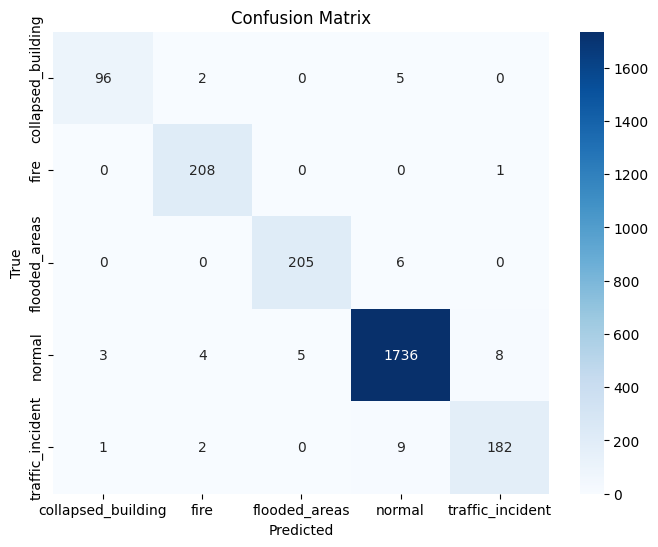

📊 test - Loss: 0.4331, Acc: 98.14%
🎯 F1-Score: 0.9665


In [13]:
test_loss, test_acc, test_report = validate(model, test_loader, criterion, device, class_names)
print(f"📊 test - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")
print(f"🎯 F1-Score: {test_report['macro avg']['f1-score']:.4f}")


Validating: 100%|██████████| 24/24 [00:11<00:00,  2.07it/s, Loss=0.4242, Acc=98.27%]


[[ 38   0   0   2   1]
 [  0  62   0   1   0]
 [  0   0  62   1   0]
 [  1   1   0 523   2]
 [  1   0   0   3  55]]


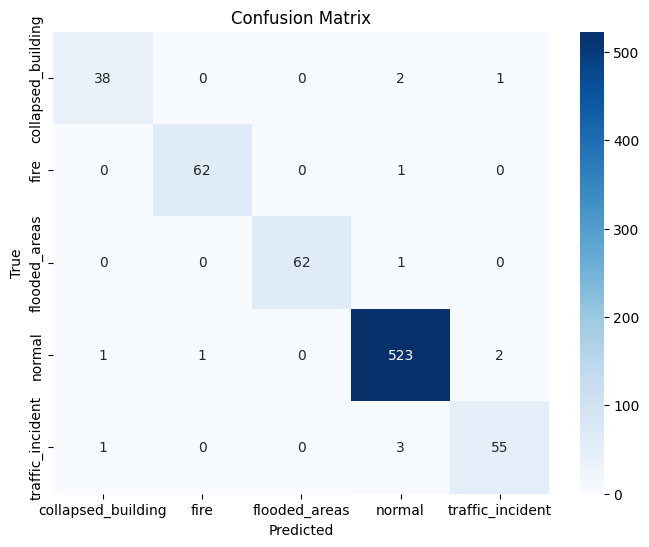

📊 test - Loss: 0.4383, Acc: 98.27%
🎯 F1-Score: 0.9688


In [14]:
val_loss, val_acc, val_report = validate(model, val_loader, criterion, device, class_names)
print(f"📊 test - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
print(f"🎯 F1-Score: {val_report['macro avg']['f1-score']:.4f}")


In [15]:
pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [16]:
from thop import profile
def calculate_flops_thop(model, input_size=(1, 3, 384, 384)):
    model.eval()
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)
    
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    
    print(f"📊 THOP Results:")
    print(f"   FLOPs: {flops:,}")
    print(f"   GFLOPs: {flops / 1e9:.4f}")
    print(f"   Parameters: {params:,}")
    print(f"   Parameters (Million): {params / 1e6:.4f}")
    
    return flops, params

# Calculate for your model
thop_flops, thop_params = calculate_flops_thop(model)

📊 THOP Results:
   FLOPs: 8,517,859,008.0
   GFLOPs: 8.5179
   Parameters: 20,835,925.0
   Parameters (Million): 20.8359


Inference time: 1.4691 seconds for 192 images
Average inference time per image: 7.65 ms


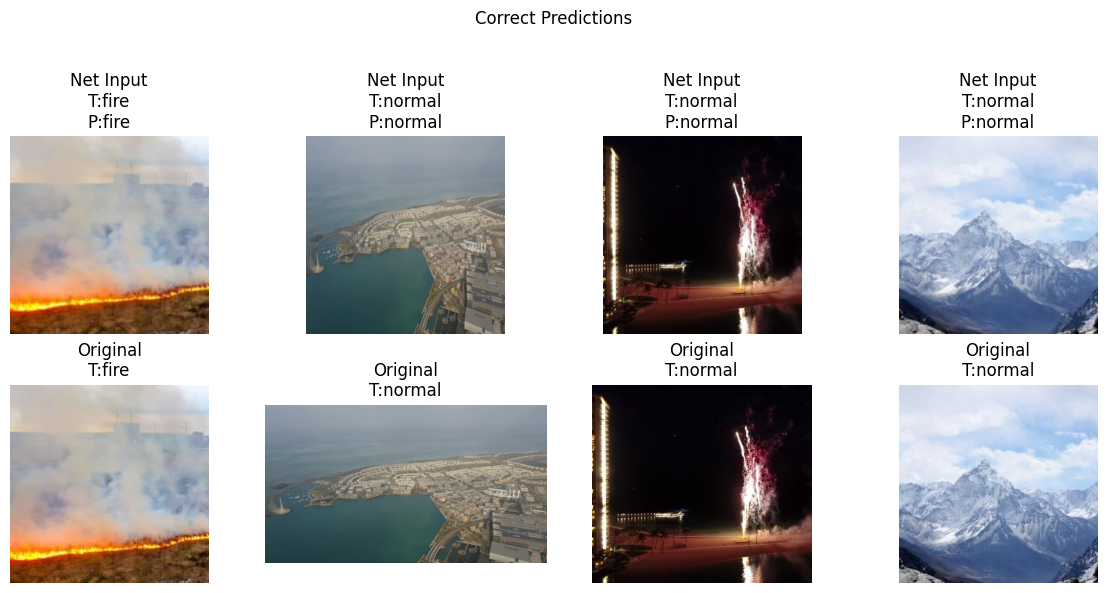

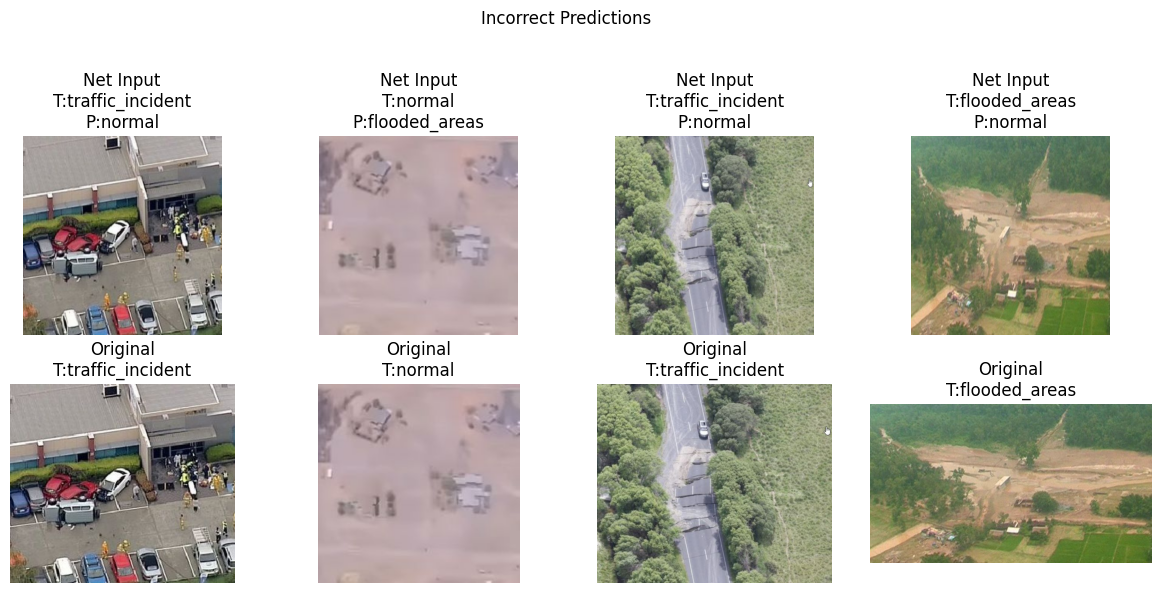

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import time

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    out = tensor.clone().cpu()
    out = out * std + mean
    out = torch.clamp(out, 0, 1)
    return out

def plot_test_results_with_original_and_inference_time(model, test_loader, class_names, device, max_per_type=4):
    """
    Plots model input and original image for correct and incorrect predictions.
    Also measures and prints average inference time per image.
    """
    model.eval()
    correct_samples = []
    wrong_samples = []
    total_images = 0
    total_infer_time = 0.0

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['labels'].to(device)
            img_paths = batch.get('image_path', [None]*len(images))
            class_batch = batch['class_name']

            # Measure inference time
            start_time = time.time()
            outputs = model(images)
            torch.cuda.synchronize() if device.type == "cuda" else None
            batch_infer_time = time.time() - start_time

            preds = outputs.argmax(1)
            total_infer_time += batch_infer_time
            total_images += len(images)

            for i in range(len(images)):
                img_model = images[i].cpu()
                label = labels[i].cpu().item()
                pred = preds[i].cpu().item()
                true_label = class_names[label]
                pred_label = class_names[pred]
                img_path = img_paths[i]
                sample = (img_model, true_label, pred_label, img_path)
                if pred == label and len(correct_samples) < max_per_type:
                    correct_samples.append(sample)
                elif pred != label and len(wrong_samples) < max_per_type:
                    wrong_samples.append(sample)
                if len(correct_samples) >= max_per_type and len(wrong_samples) >= max_per_type:
                    break
            if len(correct_samples) >= max_per_type and len(wrong_samples) >= max_per_type:
                break

    avg_time_per_image = (total_infer_time / total_images) if total_images > 0 else 0
    print(f"Inference time: {total_infer_time:.4f} seconds for {total_images} images")
    print(f"Average inference time per image: {avg_time_per_image*1000:.2f} ms")

    for typ, data in zip(["Correct Predictions", "Incorrect Predictions"], [correct_samples, wrong_samples]):
        plt.figure(figsize=(max_per_type*3, 6))
        for i, (img_model, label, pred, img_path) in enumerate(data):
            # Model input view
            plt.subplot(2, max_per_type, i+1)
            plt.imshow(denormalize(img_model).permute(1,2,0).numpy())
            plt.axis('off')
            plt.title(f"Net Input\nT:{label}\nP:{pred}")
            # Original image from disk
            plt.subplot(2, max_per_type, max_per_type + i+1)
            if img_path and os.path.exists(img_path):
                orig = Image.open(img_path).convert('RGB')
                plt.imshow(orig)
            else:
                plt.imshow(denormalize(img_model).permute(1,2,0).numpy())
            plt.axis('off')
            plt.title(f"Original\nT:{label}")
        plt.suptitle(typ)
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()

# Usage:
plot_test_results_with_original_and_inference_time(model, test_loader, class_names, device=DEVICE, max_per_type=4)
